# Analyze A/B Test Results 

This project demonstrates three approaches to evaluation of data from an experiment to make data-driven decision. We have organized the step-by-step solution into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Conclusion](#conclusion)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Set the random seed for comparison purposes
random.seed(42)

### Step 1.1 Load and examine the data set
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|

</center>

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
path = 'https://raw.githubusercontent.com/lustraka/Data_Analysis_Workouts/main/Analyse_AB_Test_Results/'
df = pd.read_csv(path+'ab_data.csv', parse_dates=['timestamp'])
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
print(f'The dataset has {df.shape[0]:,d} observations.')

The dataset has 294,478 observations.


**c.** The number of unique users in the dataset.

In [4]:
n_users = df.user_id.nunique()
print(f'The dataset contains observations for {n_users:,d} unique users.')

The dataset contains observations for 290,584 unique users.


**d.** The proportion of users converted.

In [5]:
converted = df.drop_duplicates('user_id').converted.sum()
print(f'{converted:,d} unique users were converted, so the proportion is {converted/n_users:.2%}.')

34,745 unique users were converted, so the proportion is 11.96%.


**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df.query('group == "treatment" and landing_page != "new_page"').shape[0]

1965

**f.** Do any of the rows have missing values?

In [7]:
df.isna().any().any()

False

### Step 1.2 Clean the data
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


**a.** Now create a new dataset that meets the specifications.  Store your new dataframe in **df2**.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.query('(group == "treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")').copy()

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### Step 1.3  Remove duplicates


**a.** How many unique **user_id**s are in **df2**?

In [10]:
print(f'In df2, there are {df2.user_id.nunique():,d} unique users.')

In df2, there are 290,584 unique users.


**b.** There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [12]:
repeat_user_id = df2.loc[df2.user_id.duplicated()]['user_id'].values[0]
df.query('user_id == @repeat_user_id')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Remove one of the rows with a duplicate user_id.
df2.drop_duplicates('user_id', inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2.duplicated('user_id').sum()

0

### Step 1.4  Calculate probatility

**a.** What is the probability of an individual converting regardless of the page they receive?



In [14]:
p_population = df2.converted.sum()/df2.shape[0]
print(f"The probability of converting regardless of page is {p_population:.4f}.")

The probability of converting regardless of page is 0.1196.


**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2_control = df2.query('group == "control"')
p_control = df2_control.converted.sum()/df2_control.shape[0]
print(f'The probability of converting in the control group is {p_control:.4f}.')

The probability of converting in the control group is 0.1204.


**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2_treatment = df2.query('group == "treatment"')
p_treatment = df2_treatment.converted.sum()/df2_treatment.shape[0]
print(f'The probability of converting in the treatment group is {p_treatment:.4f}.')

The probability of converting in the treatment group is 0.1188.


In [17]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment - p_control
print(f'Difference between the conversion rates is {obs_diff:.4f}')

Difference between the conversion rates is -0.0016


**d.** What is the probability that an individual received the new page?

In [18]:
p_new_page = df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]
print(f"The probability of receiving a new page is {p_new_page:.4f}")

The probability of receiving a new page is 0.5001


**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**The probability of converting in the treatment group $p_{treatment} = 11.88\% $ and the probability of converting in the control group $p_{control} = 12.04\%$. As $p_{treatment} < p_{control}$, in other words as $p_{treatment} - p_{control} = -0.0016 \leq 0$, we can conclude, that the new `treatment` group users don't lead to more coversions.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### Step 2.1 Set Hypotheses
For now, consider you need to make the decision just based on all the data provided.  


>**We set the null and alternative hypothesis in the following way:**
>
>**Null: The difference between the conversion rate in the treatment group and the conversion rate in the control group is lower or equal to zero, i.e.**
> $$H_0: p_{new} - p_{old} \leq 0$$
>
>**and**
>
>**Alternative: The difference between the conversion rate in the treatment group and the conversion rate in the control group is greater than zero, i.e.**
>$$H_1: p_{new} - p_{old} > 0$$
>
>**where $p_{old}$ is the conversion rate in the control group and $p_{new}$ is the conversion rate in the treatment group. Furthermore, we set our threshold for Type I errors $\alpha = 0.05$.**

### Step 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 

- Use a sample size for each group equal to the ones in the `df2` data.

- Compute the difference in the "converted" probability for the two samples above. 

- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [19]:
print(f'{p_population:.4f}')

0.1196


**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [20]:
print(f'{p_population:.4f}')

0.1196


**c.** What is $n_{new}$, the number of individuals in the treatment group? 

In [21]:
n_new = df2_treatment.shape[0]
print(f'{n_new:,d}')

145,310


**d.** What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2_control.shape[0]
print(f'{n_old:,d}')

145,274


**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.

In [23]:
new_page_converted = np.random.choice([1,0], size=n_new, replace=True, p=[p_population, 1.0-p_population])
new_page_converted.shape

(145310,)

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis.

In [24]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1,0], size=n_old, replace=True, p=[p_population, 1.0-p_population])
old_page_converted.shape

(145274,)

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [25]:
new_page_converted.mean() - old_page_converted.mean()

-0.0019427530394850456


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [26]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
  new_page_converted = np.random.choice([1,0], size=n_new, replace=True, p=[p_population, 1.0-p_population])
  old_page_converted = np.random.choice([1,0], size=n_old, replace=True, p=[p_population, 1.0-p_population])
  p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected? 

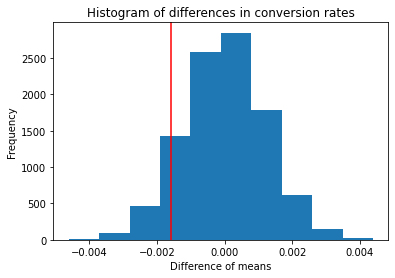

In [27]:
plt.hist(p_diffs)
plt.title('Histogram of differences in conversion rates')
plt.xlabel('Difference of means')
plt.ylabel('Frequency')
plt.axvline(x=obs_diff, c='r')
plt.show()

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [28]:
(p_diffs > obs_diff).mean()

0.9036

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**The p-value 0.9037 is significantly higher than our threshold for the Type I error rate ($\alpha = 0.05$). It means that we failed to reject the null hypothesis. In other words, there is no difference between the new and the old pages.**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 


In [29]:
import statsmodels.api as sm

# Calculate the number of conversions with the old_page
convert_old = df2_control.converted.sum()

# Calculate the number of conversions with the new_page
convert_new = df2_treatment.converted.sum()

# Calculate the number of individuals who were shown the old_page
n_old = df2_control.shape[0]

# Calculate the number of individuals who received new_page
n_new = df2_treatment.shape[0]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 in book *Introductory Statistics (Shafer and Zhang)*, courtesy [www.stats.libretexts.org](https://stats.libretexts.org/Bookshelves/Introductory_Statistics).

In [30]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?


> **The $Z_{score}$ of the test for proportions based on normal (z) test is -1.31, which is lower than 1.645, which is $Z_{\alpha}$ or $Z_{0.05}$ in our case. $Z_{score} < Z_{\alpha}$ means that we failed to reject the null hypothesis for our right-tailed test. The p-value of `proportions_ztest` is 0.9050 and is similar to our previously computed p-value, which was 0.9037.**

<a id='regression'></a>
## Part III - A regression approach

### Step 3.1 
In this final part, we will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Since each row in the `df2` is either a conversion or no conversion, i.e. the variable `converted` is a binary variable, we will use *logistic regression* that predicts categorical responses when there are only two possible outcomes.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [31]:
# Add auxiliary and dummy variables
df2['intercept'] = 1
df2['ab_page'] = df2.landing_page.apply(lambda p: 1 if p == 'new_page' else 0)

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [32]:
# Fit the model
lgm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
res = lgm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
def print_coefs(res):
  """Prints transformed coefficients to support interpretation of the results."""

  print(f'{"Variable".ljust(10)} {"Coef.".rjust(10)} | {"Exp(Coef)".rjust(10)} | {"1/Exp(Coef)".rjust(12)}')
  print('='*50)
  for k,p in res.params.items():
      print(f'{k.ljust(10)} {p:>10.4f} | {np.exp(p):>10.4f} | {1/np.exp(p):>12.4f}')
  
  return None

In [34]:
# Get summary statistics
print(res.summary2())
print_coefs(res)

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-09-29 09:10 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074

Variable        Coef. |  Exp(Coef) |  1/Exp(Coef)
intercept     -1.9888 |     0.13

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

> **The logistic regression model results suggest that the odds of converting in the treatment group is 0.9851 more likely (or 1.0151 less likely) than in the control group. In other words, there is no significant difference between treatment and contol groups.**
>
> **The p-value of 0.1899 associated with ab_page is significantly lower than p-value provided by A/B test (0.9037) or two-sample z-test (0.9050). This is because the null hypothesis in regression is that slope of a regression line is equal to zero, i.e. there is no evidence of statistically significant linear relationship between explanatory and response variables, in our case between receiving the new webpage and buing some product. The p-value changed because in regression we are testing two-sided hypothesis related to coefficients of a regression line and not one-sided hypothesis related to difference between the coversion rates.**
>
> **Even though the p-value of 0.1899 associated with ab_page is lower then in A/B testing, it is still higher than our Type I error rate (0.05) and therefore we failed to reject the null hypothesis. Both approches give the same conclusion.**

**f.** Now, we are considering other things that might influence whether or not an individual converts.

>**Human behavior is influenced by many factors and understaning these factors can improve our data-driven decision making. By building multiple linear regression models we can get deeper insight into how different variables are related. On the other side, some problems can arise, such as non-linear relationship between variables, correlated errors, non-constant variance, outliers or multicollinerity. So we must be careful in our data analysis.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. We will read in the **countries.csv** dataset and merge together our `df2` datasets on the appropriate rows. We call the resulting dataframe `df_merged`.

2. Does it appear that country had an impact on conversion?



In [35]:
# Read the countries.csv
countries = pd.read_csv(path+'countries.csv')

In [36]:
# Join with the df2 dataframe
df_merged = df2.merge(countries, on='user_id')

In [37]:
# Check missing values in the merged dataframe
df_merged.isna().any().any()

False

In [38]:
# Create the necessary dummy variables
df_merged = df_merged.join(pd.get_dummies(df_merged.country))

In [39]:
# Fit your model
lgm = sm.Logit(df_merged['converted'], df_merged[['intercept', 'CA', 'UK']])
res = lgm.fit()
# Get summary statistcs
print(res.summary2())
print_coefs(res)

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2021-09-29 09:11 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291

**h. Fit your model and obtain the results**

Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.


In [40]:
# Add interaction columns
df_merged['ab_CA'] = df_merged['ab_page'] * df_merged['CA']
df_merged['ab_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged['ab_US'] = df_merged['ab_page'] * df_merged['US']

In [41]:
# Fit your model
lgm = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'CA', 'US', 'ab_CA', 'ab_US']])
res = lgm.fit()
# Get summary statistics
print(res.summary2())
df_merged[['converted', 'ab_page','CA', 'UK', 'US', 'ab_CA', 'ab_UK', 'ab_US']].describe()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-09-29 09:11 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349

,converted,ab_page,CA,UK,US,ab_CA,ab_UK,ab_US
count,290584.000000,290584.000000,290584.000000,290584.000000,290584.000000,290584.000000,290584.000000,290584.000000
mean,0.119597,0.500062,0.049896,0.249381,0.700723,0.025125,0.124253,0.350683
std,0.324490,0.500001,0.217731,0.432655,0.457942,0.156506,0.329871,0.477185
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


>**We can see from descriptive statistics, that there are 70% of users from US, 25% of users from UK, and 5% of users from CA. Considering that chance of receiving the new webpage is 50%, the interaction between page and country gives expected results, i.e. about a half of users received the new webpage.**
>
>**The summary statictics confirm the guess, as p-values for all variables (except `intercept`, which is irrelevant) are greater then our Type I error rate $\alpha = 0.05$. We can conclude there is no practically neither statistically substantial relationship of an interaction between page and country and the conversion rate.**

<a id='finalcheck'></a>
## Final Check!

The last question is: Should the company run the experiment longer to make their decision?



In [42]:
# How long the experiment ran
df.timestamp.min(), df.timestamp.max()

(Timestamp('2017-01-02 13:42:05.378582'),
 Timestamp('2017-01-24 13:41:54.460509'))

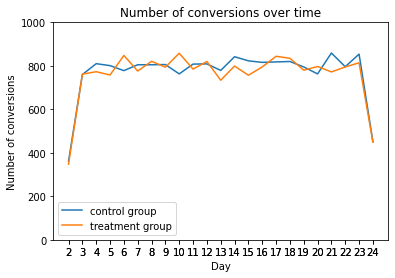

In [43]:
# Compare number of conversions within two groups across time
day_group_s = df.groupby([df.timestamp.dt.day,'group'])['converted'].sum()
plt.plot(day_group_s.xs("control", level='group'), label='control group')
plt.plot(day_group_s.xs("treatment", level='group'), label='treatment group')
plt.ylim(0,1000)
plt.xticks(day_group_s.index.get_level_values(0))
plt.title('Number of conversions over time')
plt.xlabel('Day')
plt.ylabel('Number of conversions')
plt.legend()
plt.show()

> **The experiment lasted for 23 days and there are no substantial differences between the number of conversions within both treatment and control groups. From practical point of view, there is no need to run the experiment longer, neither to examine influences associated with time on conversion.**

<a id='conclusion'></a>
## Conclusion

We examined data from the experiment from three points of view: 
- probability, 
- A/B test, 
- and regression. 

Results of all three approaches suggest that there is no practically neither statistically significant difference between the conversion rates of the old and the new webpage. **The company should keep the old webpage.** There is no need to run the experiment longer.
